In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import cv2
import time
import torch
import joblib
import shutil
import colorsys
import argparse
import numpy as np
from tqdm import tqdm
from multi_person_tracker import MPT
from torch.utils.data import DataLoader

from lib.models.vibe import VIBE_Demo
from lib.utils.renderer import Renderer
from lib.dataset.inference import Inference
from lib.utils.smooth_pose import smooth_pose
from lib.data_utils.kp_utils import convert_kps
from lib.utils.pose_tracker import run_posetracker

from lib.utils.demo_utils import (
    download_youtube_clip,
    smplify_runner,
    convert_crop_coords_to_orig_img,
    convert_crop_cam_to_orig_img,
    prepare_rendering_results,
    video_to_images,
    images_to_video,
    download_ckpt,
)

import matplotlib.pyplot as plt
import ml_collections
MIN_NUM_FRAMES = 25

### Todo
1. args.tracking_method == 'pose'<br>
2. download_ckpt(use_3dpw=True)

In [2]:
args = ml_collections.ConfigDict()
args.tracker_batch_size = 12
args.display = False # need to be false for jupyter
args.detector = 'yolo'
args.yolo_img_size = 416
args.tracking_method = 'bbox'
args.vibe_batch_size = 450
args.wireframe = False


# for args.tracking_method == 'pose'
# staf_dir = '/home/mkocabas/developments/openposetrack'

In [3]:
video_file = '/home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image_folder, num_frames, img_shape = video_to_images(video_file, return_info=True)
print(f'Input video number of frames {num_frames}')
orig_height, orig_width = img_shape[:2]
total_time = time.time()

bbox_scale = 1.1
# run multi object tracker
mot = MPT(
    device=device,
    batch_size=args.tracker_batch_size,
    display=args.display,
    detector_type=args.detector,
    output_format='dict',
    yolo_img_size=args.yolo_img_size,
)
tracking_results = mot(image_folder)

Running "ffmpeg -i /home/epinyoan/dataset/casia-b/dataset_b/Datset-B-1/video/052-nm-03-144.avi -f image2 -v error ./output/sample_video/052-nm-03-144_avi/%06d.png"
Images saved to "./output/sample_video/052-nm-03-144_avi"
Input video number of frames 101
Running Multi-Person-Tracker


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.02it/s]

Finished. Detection + Tracking FPS 56.18


In [4]:
# remove tracklets if num_frames is less than MIN_NUM_FRAMES
for person_id in list(tracking_results.keys()):
    if tracking_results[person_id]['frames'].shape[0] < MIN_NUM_FRAMES:
        del tracking_results[person_id]

# ========= Define VIBE model ========= #
model = VIBE_Demo(
    seqlen=16,
    n_layers=2,
    hidden_size=1024,
    add_linear=True,
    use_residual=True,
).to(device)

# ========= Load pretrained weights ========= #
pretrained_file = download_ckpt(use_3dpw=True)
ckpt = torch.load(pretrained_file)
print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt, strict=False)
model.eval()
print(f'Loaded pretrained weights from \"{pretrained_file}\"')

=> loaded pretrained model from 'data/vibe_data/spin_model_checkpoint.pth.tar'
Performance of pretrained model on 3DPW: 52.00081691145897
Loaded pretrained weights from "data/vibe_data/vibe_model_w_3dpw.pth.tar"


In [5]:
# ========= Run VIBE on each person ========= #
print(f'Running VIBE on each tracklet...')
vibe_time = time.time()
vibe_results = {}
for person_id in tqdm(list(tracking_results.keys())):
    bboxes = joints2d = None

    if args.tracking_method == 'bbox':
        bboxes = tracking_results[person_id]['bbox']
    elif args.tracking_method == 'pose':
        joints2d = tracking_results[person_id]['joints2d']

    frames = tracking_results[person_id]['frames']

    dataset = Inference(
        image_folder=image_folder,
        frames=frames,
        bboxes=bboxes,
        joints2d=joints2d,
        scale=bbox_scale,
    )

    bboxes = dataset.bboxes
    frames = dataset.frames
    has_keypoints = True if joints2d is not None else False

    dataloader = DataLoader(dataset, batch_size=args.vibe_batch_size, num_workers=16)

    with torch.no_grad():

        pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, smpl_joints2d, norm_joints2d = [], [], [], [], [], [], []

        for batch in dataloader:
            if has_keypoints:
                batch, nj2d = batch
                norm_joints2d.append(nj2d.numpy().reshape(-1, 21, 3))

            batch = batch.unsqueeze(0)
            batch = batch.to(device)

            batch_size, seqlen = batch.shape[:2]
            output = model(batch)[-1]

            pred_cam.append(output['theta'][:, :, :3].reshape(batch_size * seqlen, -1))
            pred_verts.append(output['verts'].reshape(batch_size * seqlen, -1, 3))
            pred_pose.append(output['theta'][:,:,3:75].reshape(batch_size * seqlen, -1))
            pred_betas.append(output['theta'][:, :,75:].reshape(batch_size * seqlen, -1))
            pred_joints3d.append(output['kp_3d'].reshape(batch_size * seqlen, -1, 3))
            smpl_joints2d.append(output['kp_2d'].reshape(batch_size * seqlen, -1, 2))


        pred_cam = torch.cat(pred_cam, dim=0)
        pred_verts = torch.cat(pred_verts, dim=0)
        pred_pose = torch.cat(pred_pose, dim=0)
        pred_betas = torch.cat(pred_betas, dim=0)
        pred_joints3d = torch.cat(pred_joints3d, dim=0)
        smpl_joints2d = torch.cat(smpl_joints2d, dim=0)
        del batch

        # ========= Save results to a pickle file ========= #
        pred_cam = pred_cam.cpu().numpy()
        pred_verts = pred_verts.cpu().numpy()
        pred_pose = pred_pose.cpu().numpy()
        pred_betas = pred_betas.cpu().numpy()
        pred_joints3d = pred_joints3d.cpu().numpy()
        smpl_joints2d = smpl_joints2d.cpu().numpy()

        # Runs 1 Euro Filter to smooth out the results
#         if args.smooth:
#             min_cutoff = args.smooth_min_cutoff # 0.004
#             beta = args.smooth_beta # 1.5
#             print(f'Running smoothing on person {person_id}, min_cutoff: {min_cutoff}, beta: {beta}')
#             pred_verts, pred_pose, pred_joints3d = smooth_pose(pred_pose, pred_betas,
#                                                                min_cutoff=min_cutoff, beta=beta)

        orig_cam = convert_crop_cam_to_orig_img(
            cam=pred_cam,
            bbox=bboxes,
            img_width=orig_width,
            img_height=orig_height
        )

        joints2d_img_coord = convert_crop_coords_to_orig_img(
            bbox=bboxes,
            keypoints=smpl_joints2d,
            crop_size=224,
        )

        output_dict = {
            'pred_cam': pred_cam,
            'orig_cam': orig_cam,
            'verts': pred_verts,
            'pose': pred_pose,
            'betas': pred_betas,
            'joints3d': pred_joints3d,
            'joints2d': joints2d,
            'joints2d_img_coord': joints2d_img_coord,
            'bboxes': bboxes,
            'frame_ids': frames,
        }

        vibe_results[person_id] = output_dict

Running VIBE on each tracklet...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


In [6]:
# prepare results for rendering
renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True, wireframe=args.wireframe)
frame_results = prepare_rendering_results(vibe_results, num_frames)
mesh_color = {k: colorsys.hsv_to_rgb(np.random.rand(), 0.5, 1.0) for k in vibe_results.keys()}
image_file_names = sorted([
    os.path.join(image_folder, x)
    for x in os.listdir(image_folder)
    if x.endswith('.png') or x.endswith('.jpg')
])
for frame_idx in tqdm(range(len(image_file_names))):
    img_fname = image_file_names[frame_idx]
    img = cv2.imread(img_fname)
    print(img.shape)
    for person_id, person_data in frame_results[frame_idx].items():
        print(frame_idx)
        frame_verts = person_data['verts']
        frame_cam = person_data['cam']
        mc = mesh_color[person_id]
        mesh_filename = None
        img = renderer.render(
            img,
            frame_verts,
            cam=frame_cam,
            color=[1,0,0],
            mesh_filename=mesh_filename,
        )

 31%|████████████████████████▊                                                        | 31/101 [00:00<00:00, 189.90it/s]

(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
30
(240, 320, 3)
31
(240, 320, 3)
32
(240, 320, 3)
33
(240, 320, 3)
34
(240, 320, 3)
35
(240, 320, 3)
36
(240, 320, 3)
37
(240, 320, 3)
38
(240, 320, 3)
39
(240, 320, 3)
40
(240, 320, 3)
41


 50%|████████████████████████████████████████▌                                         | 50/101 [00:00<00:00, 76.38it/s]

(240, 320, 3)
42
(240, 320, 3)
43
(240, 320, 3)
44
(240, 320, 3)
45
(240, 320, 3)
46
(240, 320, 3)
47
(240, 320, 3)
48
(240, 320, 3)
49
(240, 320, 3)
50
(240, 320, 3)
51


 60%|█████████████████████████████████████████████████▌                                | 61/101 [00:00<00:00, 62.15it/s]

(240, 320, 3)
52
(240, 320, 3)
53
(240, 320, 3)
54
(240, 320, 3)
55
(240, 320, 3)
56
(240, 320, 3)
57
(240, 320, 3)
58
(240, 320, 3)
59
(240, 320, 3)
60
(240, 320, 3)
61


 68%|████████████████████████████████████████████████████████                          | 69/101 [00:01<00:00, 58.17it/s]

(240, 320, 3)
62
(240, 320, 3)
63
(240, 320, 3)
64
(240, 320, 3)
65
(240, 320, 3)
66
(240, 320, 3)
67
(240, 320, 3)
68
(240, 320, 3)
69
(240, 320, 3)
70
(240, 320, 3)
71


 75%|█████████████████████████████████████████████████████████████▋                    | 76/101 [00:01<00:00, 55.02it/s]

(240, 320, 3)
72
(240, 320, 3)
73
(240, 320, 3)
74
(240, 320, 3)
75
(240, 320, 3)
76
(240, 320, 3)
77
(240, 320, 3)
78
(240, 320, 3)
79
(240, 320, 3)
80
(240, 320, 3)
81


 87%|███████████████████████████████████████████████████████████████████████▍          | 88/101 [00:01<00:00, 51.84it/s]

(240, 320, 3)
82
(240, 320, 3)
83
(240, 320, 3)
84
(240, 320, 3)
85
(240, 320, 3)
86
(240, 320, 3)
87
(240, 320, 3)
88
(240, 320, 3)
89
(240, 320, 3)
90
(240, 320, 3)
91


 99%|████████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:01<00:00, 47.95it/s]

(240, 320, 3)
92
(240, 320, 3)
93
(240, 320, 3)
94
(240, 320, 3)
95
(240, 320, 3)
96
(240, 320, 3)
97
(240, 320, 3)
98
(240, 320, 3)
99
(240, 320, 3)
100


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 58.96it/s]


(6890, 3) (13776, 3)


/home/epinyoan/miniconda3/envs/vibe-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


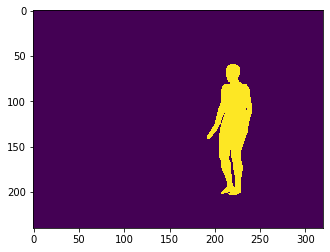

In [8]:
# frame_cam_ = output['theta'][:, :, :3].reshape(batch_size * seqlen, -1)
verts_ = output['verts'].reshape(batch_size * seqlen, -1, 3)
img = renderer.render(
    img,
    verts_[20].cpu().numpy(),
    cam=orig_cam[20],
    color=[1,0,0],
    mesh_filename=None,
)

plt.imshow(img.astype(np.int).squeeze(axis=2))